In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler


# Local
from data_loader import get_train_valid_loaders


import warnings
warnings.filterwarnings('ignore')

In [3]:
# GLOBALS
# --------------------------------

data_dir = 'data/cifar10'
random_seed = 1

# CIFAR10 labels
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

# HYPERPARAMETERS 
# --------------------------------
# see section 4.2 of paper

weight_decay = 0.0001
momentum = 0.9

# minimum batch size of 128 on two GPUs
batch_size = 128

# We start with a learning rate of 0.1, 
# divide it by 10 at 32k and 48k iterations
learning_rate = 0.1

# 45k/5k train/val split
valid_size = 0.1

# Other details
# weight initialisation [12]
# batch normalisation [16]
# no dropout
# 64k training iterations



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


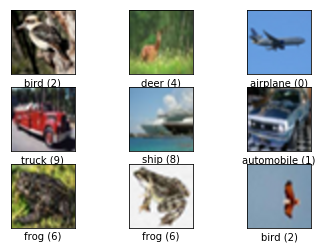

In [5]:
# LOAD DATA

# [ ] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.

# Normalisation parameters fo CIFAR10
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomResizedCrop(32, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

valid_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

train_loader, valid_loader = get_train_valid_loaders(data_dir,
                                                     batch_size,
                                                     train_transform,
                                                     valid_transform,
                                                     label_names=label_names,
                                                     random_seed=random_seed,
                                                     valid_size=valid_size,
                                                     shuffle=True,
                                                     show_sample=True,
                                                     num_workers=4,
                                                     pin_memory=False)

In [11]:
class PlainNet(torch.nn.Module):
    def __init__(self):
        super(PlainNet, self).__init__()
        self.convIn = torch.nn.Conv2d(3, 16, 3, stride=1, padding=1, bias=True)
        self.conv1a = torch.nn.Conv2d(16, 16, 3, stride=1, padding=1, bias=True)
        self.conv1b = torch.nn.Conv2d(16, 32, 3, stride=2, padding=1, bias=True)
        self.conv2a = torch.nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=True)
        self.conv2b = torch.nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=True)
        self.conv3a = torch.nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=True)
        self.pool = torch.nn.AvgPool2d(2)
        self.fcOut  = torch.nn.Linear(64*4*4, 10)  
        
    def forward(self, x):
        n = 3
        # Input layer
        x = F.relu(self.convIn(x))
        
        # Hidden Layers
        # 32
        for _ in range(2*n-1):
            x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        
        # 16
        for _ in range(2*n-1):
            x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        
        # 8
        for _ in range(2*n):
            x = F.relu(self.conv3a(x))
        
        # Ouput
        x = self.pool(x)
        x = x.view(-1, 64*4*4)
        x = self.fcOut(x)
        
        return x
        
        



In [12]:
net = PlainNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')